In [28]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random, uuid, time
from collections import deque, namedtuple

plt.rcParams["animation.html"] = "jshtml"

In [29]:
Message = namedtuple("Message", "id src dst gen_t deadline delivered_t")

class GroundNode:
    def __init__(self, idx, pos):
        self.idx = idx
        self.pos = np.array(pos, dtype=float)
        self.queue = deque()

class UAV:
    def __init__(self, idx, pos, speed, capacity):
        self.idx = idx
        self.pos = np.array(pos, dtype=float)
        self.speed = speed
        self.capacity = capacity
        self.buffer = []
        self.waypoints = []
        self.wp_idx = 0

In [30]:
class SingleRoutePolicy:
    def __init__(self, nodes, n_uav):
        self.nodes = nodes
        self.tour  = self._greedy_tsp([n.pos for n in nodes])
        self.n_uav = n_uav

    @staticmethod
    def _greedy_tsp(pts):
        remaining = set(range(1, len(pts)))
        tour = [0]
        while remaining:
            last = tour[-1]
            nxt  = min(remaining, key=lambda j: np.linalg.norm(pts[last]-pts[j]))
            tour.append(nxt); remaining.remove(nxt)
        return tour

    def initial_uavs(self, speed, cap):
        pts = [self.nodes[i].pos for i in self.tour]
        dist = np.cumsum([0]+[np.linalg.norm(pts[i]-pts[i-1]) for i in range(1,len(pts))])
        total, spacing = dist[-1], dist[-1]/self.n_uav
        uavs=[]
        for k in range(self.n_uav):
            target = k*spacing
            idx = np.searchsorted(dist, target)-1
            frac = (target-dist[idx])/(dist[idx+1]-dist[idx]+1e-9)
            start = pts[idx]*(1-frac)+pts[idx+1]*frac
            u = UAV(k, start, speed, cap); u.waypoints = self.tour; uavs.append(u)
        return uavs


In [31]:
class Simulator:
    """
    Lightweight DTN-with-UAVs simulator.
    – Single-route (greedy TSP) policy
    – Store–carry–forward message handling
    – Deadline drops
    """

    def __init__(self, n_nodes: int = 25, area: float = 100,
                 n_uav: int = 5, speed: float = 1.0, capacity: int = 30,
                 lam: float = 1.0, deadline: int = 100, comm_range: float = 5,
                 sim_time: int = 500, seed: int = 0):
        random.seed(seed)
        np.random.seed(seed)

        # world params
        self.area        = area
        self.comm_range  = comm_range
        self.deadline    = deadline
        self.sim_time    = sim_time
        self.dt          = 1
        self.time        = 0

        # ground nodes
        self.nodes = [GroundNode(i, np.random.rand(2) * area)
                      for i in range(n_nodes)]

        # routing policy & UAV fleet
        self.policy = SingleRoutePolicy(self.nodes, n_uav)
        self.uavs   = self.policy.initial_uavs(speed, capacity)

        # traffic generation (Poisson)
        self.lam           = lam
        self.next_arrival  = self._next_arrival()

        # stats
        self.msgs_generated = 0
        self.delivered: list[Message] = []
        self.dropped = 0

    # Helper functions
    
    def _next_arrival(self) -> float:
        """next Poisson‐arrival time"""
        return self.time + np.random.exponential(1 / self.lam)

    def _generate_message(self):
        """pick random src / dst, enqueue at src"""
        src, dst = random.sample(self.nodes, 2)
        m = Message(str(uuid.uuid4()), src.idx, dst.idx,
                    self.time, self.time + self.deadline, None)
        src.queue.append(m)
        self.msgs_generated += 1

    # ------------------------------------------------------------------ #
    #                         single time-step                            #
    # ------------------------------------------------------------------ #
    def step(self):
        # 1. new traffic
        if self.time >= self.next_arrival:
            self._generate_message()
            self.next_arrival = self._next_arrival()

        # 2. UAV motion & transfers
        for u in self.uavs:
            tgt = self.nodes[u.waypoints[u.wp_idx]].pos
            vec = tgt - u.pos
            dist = np.linalg.norm(vec)
            step = min(u.speed, dist)
            if dist > 1e-6:
                u.pos += vec / dist * step

            # reached target node?
            if dist <= 1e-3:
                node = self.nodes[u.waypoints[u.wp_idx]]

                # (a) deliver
                keep = []
                for m in u.buffer:
                    if m.dst == node.idx:
                        self.delivered.append(
                            m._replace(delivered_t=self.time))
                    else:
                        keep.append(m)
                u.buffer = keep

                # (b) pick-up
                while node.queue and len(u.buffer) < u.capacity:
                    u.buffer.append(node.queue.popleft())

                # (c) next waypoint
                u.wp_idx = (u.wp_idx + 1) % len(u.waypoints)

            # (d) on-board deadline expiry
            new_buf = []
            for m in u.buffer:
                if self.time > m.deadline:
                    self.dropped += 1
                else:
                    new_buf.append(m)
            u.buffer = new_buf

        # 3. drop expired msgs still in queues
        for n in self.nodes:
            keep = deque()
            while n.queue:
                m = n.queue.popleft()
                if self.time > m.deadline:
                    self.dropped += 1
                else:
                    keep.append(m)
            n.queue = keep

        # 4. advance time 
        self.time += self.dt

    # full run 
    def run(self):
        while self.time < self.sim_time:
            self.step()
        self.report()

    # report stats 
    def report(self):
        on_time = len(self.delivered)
        pct     = on_time / self.msgs_generated * 100 if self.msgs_generated else 0
        avg_del = (np.mean([m.delivered_t - m.gen_t for m in self.delivered])
                   if self.delivered else None)

        print(f"Generated : {self.msgs_generated}")
        print(f"Delivered : {on_time} ({pct:.1f} %)")
        print(f"Dropped   : {self.dropped}")
        print("Avg delay : "
              f"{avg_del:.1f}" if avg_del is not None else "Avg delay : N/A")


In [32]:
def visualise_sim(sim: Simulator, interval=100, save_as=None,
                  show_trails=True, show_tour=True):
    """
    Re-runs *sim* to gather frames, then animates.
    save_as : 'demo.gif' or 'demo.mp4'  (needs Pillow or FFmpeg)
    """
    # ---------- re-run & capture positions -------------------------------
    sim.time = 0
    sim.next_arrival = sim._next_arrival()
    frames=[]; trails=[[] for _ in sim.uavs]
    while sim.time < sim.sim_time:
        frames.append([(u.pos.copy(), len(u.buffer)) for u in sim.uavs])
        for k,u in enumerate(sim.uavs): trails[k].append(u.pos.copy())
        sim.step()

    nodes = np.array([n.pos for n in sim.nodes])
    tour  = np.array([sim.nodes[i].pos for i in sim.policy.tour])

    # ---------- Matplotlib animation ------------------------------------
    fig, ax = plt.subplots(figsize=(6,6)); ax.set_aspect('equal')
    lim = sim.area + 5
    ax.set_xlim(-5, lim); ax.set_ylim(-5, lim)
    ax.set_title("UAV-DTN Ferry")
    ax.scatter(nodes[:,0], nodes[:,1], c='k', s=25, label='Ground nodes')
    if show_tour:
        ax.plot(tour[:,0], tour[:,1], '--', lw=1, color='grey', label='Tour')

    scat = ax.scatter([], [], s=60, cmap='RdYlGn_r',
                      vmin=0, vmax=sim.uavs[0].capacity,
                      label='UAVs (colour = buffer load)')
    trail_lines = [ax.plot([], [], alpha=0.25)[0] for _ in sim.uavs] if show_trails else None
    ax.legend(loc='upper right')

    def update(i):
        pos, loads = zip(*frames[i])
        pos = np.array(pos)
        scat.set_offsets(pos)
        scat.set_array(np.array(loads))
        if show_trails:
            for line, tr in zip(trail_lines, trails):
                if i < len(tr):
                    arr = np.array(tr[:i+1])
                    line.set_data(arr[:,0], arr[:,1])
        return scat,

    ani = FuncAnimation(fig, update, frames=len(frames),
                        interval=interval, blit=True, repeat=False)

    if save_as:  # export
        ani.save(save_as, dpi=110)
        print("Saved", save_as)
    plt.show()
    return ani


/tmp/ipykernel_11048/4248076541.py:28: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  scat = ax.scatter([], [], s=60, cmap='RdYlGn_r',
MovieWriter ffmpeg unavailable; using Pillow instead.


Generated : 169
Delivered : 4 (2.4 %)
Dropped   : 122
Avg delay : 27.2
Saved demo.gif


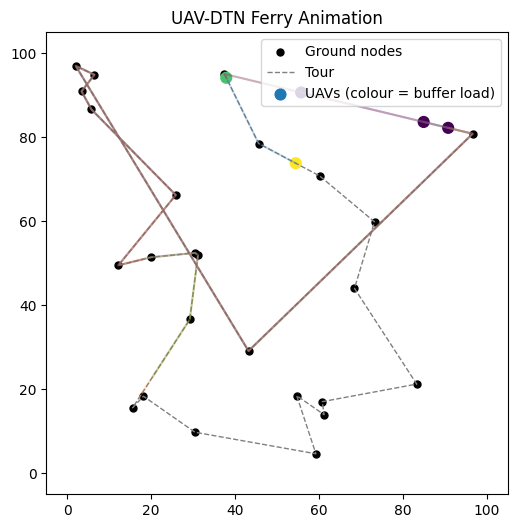

In [33]:
sim = Simulator(n_nodes=25, n_uav=5, lam=0.8,
                deadline=80, sim_time=300, seed=42)
sim.run()                          

# save_as="demo.gif" or "demo.mp4" 
_ = visualise_sim(sim, interval=80, save_as="demo.gif",
                  show_trails=True, show_tour=True)